# 决策树实战

## 01 What is Decision Tree

先来看一个简单的决策树代码，使用scikit-learn里的DecisionTreeClassifier。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

%matplotlib inline

In [2]:
# 加载鸢尾花卉数据集
iris = datasets.load_iris()

In [3]:
iris.data.shape

(150, 4)

In [4]:
iris.target.shape

(150,)

In [5]:
# 设置X
X = iris.data[:, 2:]
print(X[:10])
print(X.shape)

[[1.4 0.2]
 [1.4 0.2]
 [1.3 0.2]
 [1.5 0.2]
 [1.4 0.2]
 [1.7 0.4]
 [1.4 0.3]
 [1.5 0.2]
 [1.4 0.2]
 [1.5 0.1]]
(150, 2)


In [6]:
# 设置y
y = iris.target
print(y[:10])
print(y.shape)

[0 0 0 0 0 0 0 0 0 0]
(150,)


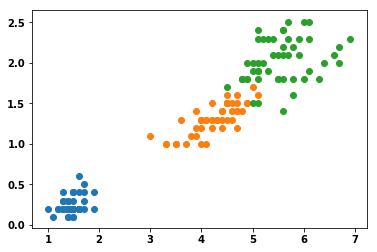

In [7]:
# 观察数据分布
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

In [8]:
from sklearn.tree import DecisionTreeClassifier

In [9]:
# 设置决策树分类器并训练数据，使用最大信息增益作为分类条件
dt_clf_entropy = DecisionTreeClassifier(max_depth=2, criterion='entropy', random_state=42)
dt_clf_entropy.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [10]:
# 设置决策树分类器并训练数据，使用基尼指数作为分类条件
dt_clf_gini = DecisionTreeClassifier(max_depth=2, criterion="gini", random_state=42)
dt_clf_gini.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

绘制决策边界，更直观的了解决策树是怎么划分数据的。

In [11]:
def plot_decision_boundary(model, axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0, x1, zz, cmap=custom_cmap)

查看根据最大信息增益分类后的情况

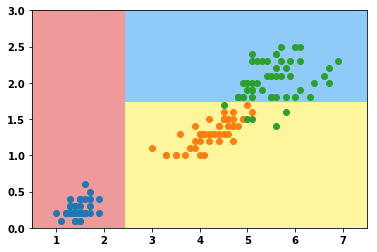

In [12]:
plot_decision_boundary(dt_clf_entropy, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

查看根据基尼指数分类后的情况

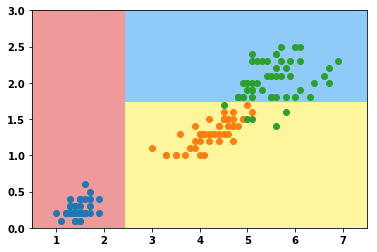

In [13]:
plot_decision_boundary(dt_clf_gini, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

## 02 Entropy

决策树又称为判定树，是运用于分类的一种树结构，其中的**每个内部节点代表对某一属性的一次测试**，每条边代表一个测试结果，叶节点代表某个类或类的分布。

那么如何确定**每个节点在哪个特征上做划分?每个特征在哪个值上做划分?**

引入信息论中的熵的概念。

熵在信息学中代表随机变量不确定度的度量。熵越大，数据的不确定性越高。

所以可以通过划分前后熵的变化来确定每个节点的特征和每个特征的值的选择。

经验熵的公式为:

$$ H = - \sum_{i=1}^k p_i \log(p_i) $$

In [14]:
# 计算熵
def entropy(p):
    return -p * np.log(p) - (1 - p) * np.log(1 - p)

In [15]:
# 设置测试数据
X = np.linspace(0.01, 0.99, 200)

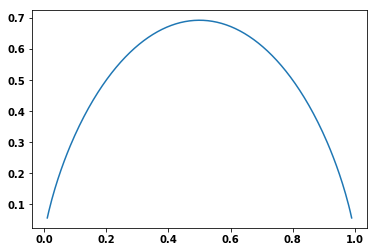

In [16]:
# 可视化
plt.plot(X, entropy(X))
plt.show()

## 03 Entropy Split Simulation - ID3

通过最大化节点划分前后熵的差值，就是ID3

In [17]:
from collections import Counter

In [18]:
# 根据当前特征和划分边界值划分数据集
def split(X, y, feature, split_value):
    index_left = (X[:,feature] <= split_value)
    index_right = (X[:,feature] > split_value)
    return X[index_left], X[index_right], y[index_left], y[index_right]

In [19]:
# 计算经验熵
def entropy(y):
    counter = Counter(y)
    res = 0.0
    for num in counter.values():
        p = num / len(y)
        res += - p * np.log(p)
    return res

In [20]:
# 找到最大的信息熵差值，最优的划分特征和最优的划分边界
def try_split_entropy(X, y):
    # 初始化最小entropy
    best_entropy = float('inf')
    
    # 初始化最优划分特征和最优划分边界
    best_feature, best_value = -1, -1
    
    # 遍历每个划分特征
    for feature in range(X.shape[1]):
        # 获得样本按照特征的数值升序排序后的index
        sorted_index = np.argsort(X[:,feature])
        
        # 从第二个样本开始遍历每个样本
        for i in range(1, len(X)):
            
            # 判断当前样本和前一个样本的特征值是否一致
            if X[sorted_index[i], feature] != X[sorted_index[i - 1], feature]:
                
                # 获取划分边界值，将当前样本和前一个样本的均值作为划分边界
                split_value = (X[sorted_index[i], feature] + X[sorted_index[i - 1], feature]) / 2
                
                # 根据当前特征和划分边界值划分数据集
                X_left, X_right, y_left, y_right = split(X, y, feature, split_value)
                
                # 计算划分后的entropy
                e = entropy(y_left) + entropy(y_right)
                
                # 取entropy的最小值
                if e < best_entropy:
                    best_entropy, best_feature, best_value = e, feature, split_value
                    
    return best_entropy, best_feature, best_value

测试

In [21]:
# 设置X和y
X = iris.data[:, 2:]
y = iris.target

第一次划分

In [22]:
best_entropy1, best_feature1, best_value1 = try_split_entropy(X, y)
print("best_entropy1 =", best_entropy1)
print("best_feature1 =", best_feature1)
print("best_value1 =", best_value1)

best_entropy1 = 0.6931471805599453
best_feature1 = 0
best_value1 = 2.45


In [23]:
X1_l, X1_r, y1_l, y1_r = split(X, y, best_feature1, best_value1)

In [24]:
entropy(y1_l)

0.0

In [25]:
entropy(y1_r)

0.6931471805599453

第二次划分，划分右边的数据集

In [26]:
best_entropy2, best_feature2, best_value2 = try_split_entropy(X1_r, y1_r)
print("best_entropy2 =", best_entropy2)
print("best_feature2 =", best_feature2)
print("best_value2 =", best_value2)

best_entropy2 = 0.4132278899361904
best_feature2 = 1
best_value2 = 1.75


In [27]:
X2_l, X2_r, y2_l, y2_r = split(X1_r, y1_r, best_feature2, best_value2)

In [28]:
entropy(y2_l)

0.30849545083110386

In [29]:
entropy(y2_r)

0.10473243910508653

## 04 Gini Index

基尼指数代表了模型的纯度，基尼指数越小，则纯度越高，特征越好。 

具体的，在分类问题中，假设有$K$个类别，第$k$个类别的概率为$p_k$, 则基尼指数的表达式为:

$$ Gini(p) = 1 - \sum_{k=1}^K p_k^2 $$

**信息熵 VS 基尼指数**<br>
- 信息熵计算较慢(涉及大量对数运算)
- scikit-learn中默认为基尼系数
- 大多数时候二者没有特别的效果优劣

模拟使用基尼系数划分

In [30]:
# 计算基尼指数
def gini(y):
    counter = Counter(y)
    res = 1.0
    for num in counter.values():
        p = num / len(y)
        res -= p**2
    return res

In [31]:
def try_split_gini(X, y):
    # 初始化最小基尼指数
    best_gini = float('inf')
    
    # 初始化最优划分特征和最优划分边界
    best_feature, best_value = -1, -1
    
    # 遍历每个划分特征
    for feature in range(X.shape[1]):
        # 获得样本按照特征的数值升序排序后的index
        sorted_index = np.argsort(X[:,feature])
        
        # 从第二个样本开始遍历每个样本
        for i in range(1, len(X)):
            
            # 判断当前样本和前一个样本的特征值是否一致
            if X[sorted_index[i], feature] != X[sorted_index[i - 1], feature]:
                
                # 获取划分边界值，将当前样本和前一个样本的均值作为划分边界
                split_value = (X[sorted_index[i], feature] + X[sorted_index[i - 1], feature]) / 2
                
                # 根据当前特征和划分边界值划分数据集
                X_left, X_right, y_left, y_right = split(X, y, feature, split_value)
                
                # 计算划分后的gini
                g = gini(y_left) + gini(y_right)
                
                # 取gini的最小值
                if g < best_gini:
                    best_gini, best_feature, best_value = g, feature, split_value
                    
    return best_gini, best_feature, best_value

测试

In [32]:
# 设置X和y
X = iris.data[:, 2:]
y = iris.target

第一次划分

In [33]:
best_gini1, best_feature1, best_value1 = try_split_gini(X, y)
print("best_gini1 =", best_gini1)
print("best_feature1 =", best_feature1)
print("best_value1 =", best_value1)

best_gini1 = 0.5
best_feature1 = 0
best_value1 = 2.45


In [34]:
X1_l, X1_r, y1_l, y1_r = split(X, y, best_feature1, best_value1)

In [35]:
gini(y1_l)

0.0

In [36]:
gini(y1_r)

0.5

第二次划分，划分右边的数据集

In [37]:
best_gini2, best_feature2, best_value2 = try_split_gini(X1_r, y1_r)
print("best_gini2 =", best_gini2)
print("best_feature2 =", best_feature2)
print("best_value2 =", best_value2)

best_gini2 = 0.2105714900645938
best_feature2 = 1
best_value2 = 1.75


In [38]:
X2_l, X2_r, y2_l, y2_r = split(X1_r, y1_r, best_feature2, best_value2)

In [39]:
gini(y2_l)

0.1680384087791495

In [40]:
gini(y2_r)

0.04253308128544431

## 05 CART and Decisioin Tree Hyperparameters

分析一下skitit learn中DecisionTreeClassifier(默认为CART)的超参数。使用sklearn中的moons数据集。

数据分布

In [41]:
from sklearn import datasets

X, y = datasets.make_moons(noise=0.25, random_state=666)

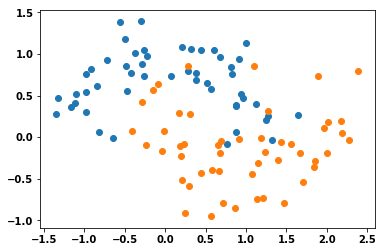

In [42]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

### 不传超参数时的决策边界

In [43]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

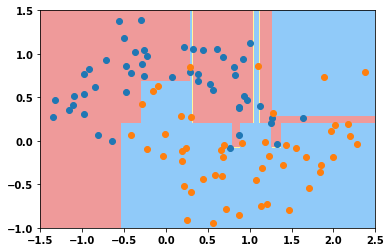

In [44]:
plot_decision_boundary(dt_clf, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

**可以看到过拟合的情况发生。**

### 加超参数max_depth=2

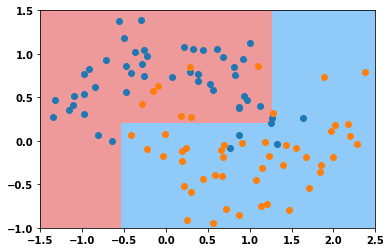

In [45]:
dt_clf2 = DecisionTreeClassifier(max_depth=2)
dt_clf2.fit(X, y)

plot_decision_boundary(dt_clf2, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

**可以看到效果好了很多**

### 加超参数min_samples_split=10，内部节点再划分所需最小样本数，默认值为2。

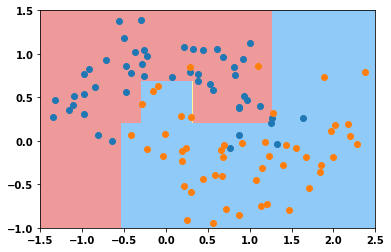

In [46]:
dt_clf3 = DecisionTreeClassifier(min_samples_split=10)
dt_clf3.fit(X, y)

plot_decision_boundary(dt_clf3, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

**显而易见，节点再划分所需的样本数提高，可以增加泛化能力。**

### min_samples_leaf=6

叶是决策树的末端节点。较小的叶子使模型更容易捕捉训练数据中的噪声。一般来说，更偏向于将最小叶子节点数目设置为大于50。在具体的情况中，应该尽量尝试多种叶子大小种类，以找到最优的那个。

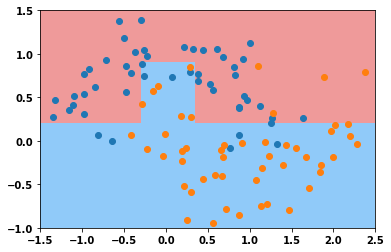

In [47]:
dt_clf4 = DecisionTreeClassifier(min_samples_leaf=6)
dt_clf4.fit(X, y)

plot_decision_boundary(dt_clf4, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

### max_leaf_nodes=4

通过限制最大叶子节点数，可以防止过拟合，默认是"None”，即不限制最大的叶子节点数。如果加了限制，算法会建立在最大叶子节点数内最优的决策树。如果特征不多，可以不考虑这个值，但是如果特征分成多的话，可以加以限制，具体的值可以通过交叉验证得到。

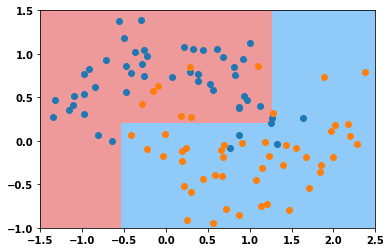

In [48]:
dt_clf5 = DecisionTreeClassifier(max_leaf_nodes=4)
dt_clf5.fit(X, y)

plot_decision_boundary(dt_clf5, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()